# Introduction

- L'objectif de ce notebook:
1. Présenter les bases de données existantes en chinois
2. Appliquer les méthodes de word embedding existantes

In [1]:
import numpy as np
import re
import fasttext
import time
import multiprocessing
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import pandas as pd
import subprocess
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

----
# 1.La présentation des jeux de données de texte existantes en chinois

- Nous avons trouvé un corpus chinois. Le sujet de corpus est la nouvelle. L'origine de corpus est le toolbox [THUCTC](http://thuctc.thunlp.org/, "THUCTC: 一个高效的中文文本分类工具"), une boîte d'outils pour la classification de textes chinois. Ce corpus contient 14 catégories de nouvelles. Chaque nouvelle est stockée dans un fichier .txt qui se trouve dans son propre dossier de catégorie correspondant. Voici le bilan de toutes les nouvelles.

| Catégorie | Nombre de nouvelles |
| :--------: | -----------------: |
| Sport | 131604 |
| Divertissement | 92632 |
| Maison | 32586 |
| Loterie | 7588 |
| Propriété | 20050 |
| Éducation | 41936 |
| Mode | 13368 |
| Affaire | 63086 |
| Constellation | 3578 |
| Jeu de vidéo | 24373 |
| Société | 50849 |
| Science et Technologie | 162929 |
| Action | 154398 |
| Finance et Économie | 37098 |
| **Totale** | **836075**|

- Le corpus utilisé dans ce notebook est un corpus de nouvelles de THUCTC <https://blog.csdn.net/lxg0807/article/details/52960072>. 10000 nouvelles ont été sélectionné dans chaque catégorie et ensuite ont été mis dans un seul fichier pour l'entraînement. Pour les catégories qui ne comportent pas 10000 pièces, toutes ses nouvelles ont été sélectionnées. Le jeu de données de test suit le même principe. Cependant, il ne contient pas de catégorie qui possède moins que 10000 nouvelles parce qu'ils sont tous dans le jeu de données d'apprentissage. Le [détail du code](https://blog.csdn.net/lxg0807/article/details/52776183).

- Les jeux de données utilisés dans ce notebook peuvent être téléchargés:

    [news_fasttext_train.txt](https://drive.google.com/file/d/1rF8jaifMPug2QSxYTfSJuAI6ThUEsGBi/view?usp=sharing)

    [news_fasttext_test.txt](https://drive.google.com/file/d/1psrAH5heISv3t2xuB4YKxUCvsUN6yU6C/view?usp=sharing)
    


-------------
Pour commencer, nous allons lire le jeu de données d'apprentissage et montrer quelques exemples de nouvelles.

In [2]:
with open('datasets/news_fasttext_train.txt') as f:
    f_news = f.readlines()
    
for i in range(2):
    print(f_news[i*40001])
print("Nombre de nouvelles: " + str(len(f_news)))
del(f_news)

英媒称 威廉 王子 圣诞节 前 将 宣布 订婚   　 　 中新网 11 月 8 日电   据 香港 《 文汇报 》 报道 ， 英媒称 英国 威廉 王子 和 女友 凯蒂 将 于 圣诞节 前 宣布 订婚 ， 并 于 明年 7 月 23 日拉埋 天窗 ， 结束 8 年 爱情 长跑 ， 并 计划 婚后 生儿育女 ， 组织 幸福家庭 。   　 　 报道 指 ， 28 岁 的 凯蒂 预定 与 王室 成员 一起 ， 在 诺福克郡 桑德灵 厄姆堡 欢度 圣诞节 ， 但 她 须 先 与 威廉 订婚 才 可 获邀 出席 。 消息人士 透露 ， 一切 安排 都 是 为 两人 明年 的 婚事 铺路 ， 而且 “ 进展 迅速 ” 。   　 　 两人 决定 在 温莎堡 乔治 教堂 低调 成婚 ， 这里 也 是 王储 查尔斯 和 卡米拉 2005 年 结婚 之 处 。 据悉 英女王 也 希望 在 政府 紧缩 开支 时 ， 避免 婚事 太 铺张浪费 。   　 　 传媒 本周 拍摄 到 凯蒂 父母 在 女王 位于 苏格兰 的 巴尔 莫 勒尔 堡 打猎 ， 更 获 女王 批准 在 附近 一间 王宫 住宿 ， 令 威廉 、 凯蒂 快 将 宣布 婚事 的 传闻 甚嚣尘上 。   　 　 另外 ， 女王 跟随 威廉 、 哈里 王子 和 其他 年轻 王室 成员 ， 正式 加入 大热 社交 网站 facebook ， 成立 王室 官方 页面 ， 公布 王室 活动 、 照片 、 影片 、 新闻 和 发言 。 facebook 用家 对 页面 点击 “ 赞 ” ( like ) ， 就 可 定期 收到 活动 更新 。   　 　 中新网 11 月 8 日电   据 香港 《 文汇报 》 报道 ， 英媒称 英国 威廉 王子 和 女友 凯蒂 将 于 圣诞节 前 宣布 订婚 ， 并 于 明年 7 月 23 日拉埋 天窗 ， 结束 8 年 爱情 长跑 ， 并 计划 婚后 生儿育女 ， 组织 幸福家庭 。   　 　 报道 指 ， 28 岁 的 凯蒂 预定 与 王室 成员 一起 ， 在 诺福克郡 桑德灵 厄姆堡 欢度 圣诞节 ， 但 她 须 先 与 威廉 订婚 才 可 获邀 出席 。 消息人士 透露 ， 一切 安排 都 是 为 两人 明年 的 婚事 铺路 ， 而且 “ 进展 迅速 ” 。   　 　 两人 决定 在 

----
Nous avons vu, chaque ligne du text contient une nouvelle. Tous les mots chinois ont été séparés par un espace. Les charactères liées correspondent un mot en chinois. À la fin de chaque ligne, une étiquette du sujet est marquée, avec préfix "\_\_label__".

Le nombre totale de nouvelles dan ce jeu d'apprentissage est 121155.

Le nombre de mots avec 5 fois d'occurrence au minimum, donc le nombre de mot de vocabulaire est **183311**.

----
# 2. Prétraitement des données

Nous allons maintenant construire le jeu de données pour entraîner des vecteurs de Word Embedding.
- D'abord, nous allons éliminer les mots non chinois et les étiquettes. Vue que l'entraînement de vecteurs de mots est l'apprentissage non supervisé, les étiquettes ne sont pas utiles.
- Dans ce cas là, nous allons définir une méthode pour éliminer les mots non chinois et les étiquettes.

In [3]:
def filter(s):
    """
    Output only Chinese characters
    """
    filtrate = re.compile(u'[^\u4E00-\u9FA5]')
    res = filtrate.sub(r' ', s)
    return res

- Vue que la taille de données est assez grande, pour réduire l'utilisation de mémoire, nous allons faire le prétraitement de données ligne par ligne.

In [4]:
with open('datasets/news_fasttext_train.txt') as origin:
    with open('datasets/news_pure_nolabel.txt', 'w') as f:
        for line in origin:
            temp = filter(line).replace('  ', '')
            f.write("{}\n".format(temp))

- Nous avons écrit les données dans un fichier, qui peut être téléchargé via [news_pure_nolabel.txt](https://drive.google.com/file/d/1raU-oYJiZDa1U2bQcUrOuwilsQ3x49XC/view?usp=sharing).

----
- Nous allons également pré-traiter le jeu de test.

In [4]:
with open('datasets/news_fasttext_test.txt') as origin:
    with open('datasets/test_pure_nolabel.txt', 'w') as f:
        for line in origin:
            temp = filter(line).replace('  ', '')
            f.write("{}\n".format(temp))

- Nous avons écrit les données dans un fichier, qui peut être téléchargé via [test_pure_nolabel.txt](https://drive.google.com/file/d/1ksOGlYD3JAOmdD0yO1hNgdP7u-peVd8D/view?usp=sharing).

----
# 3. Entraîner le classifieur de texte par FastText

Dans le corpus d'apprentissage, il existe deux catégories, constellation et loterie, qui ne sont pas présent dans le corpus de test à cause de la manque de données. Afin d'utiliser ces données pour tester le classifieur de [FastText](https://pypi.org/project/fasttext/), nous allons d'abord construire un autre jeu d'apprentissage qui ne comporte pas ces deux catégories. Ce fichier peut être télécharger via [news_less_category.txt](https://drive.google.com/file/d/11kUgD4HhqRqhEhS_6yTx_QOXKCWGF3U8/view?usp=sharing).

In [41]:
with open('datasets/news_fasttext_train.txt') as origin:
    with open('datasets/news_less_category.txt', 'w') as f:
        for line in origin:
            label = line.split('\t')[1]
            if "constellation" in label or "lottery" in label:
                continue
            f.write(line)

Maintenant nous allons entraîner le classifieur.
- Dans le papier, le classifier supervisé de fasttext utilise un modèle qui resemble au model CBOW. Mais la sortie du modèle est directement les étiquettes de textes qui remplacent les mots d'embedding.
- Dans le package que l'on utilise, c'est la même théorie.

In [42]:
tic = time.time()
clf = fasttext.supervised('datasets/news_less_category.txt', 'model')
toc = time.time()
print('Time used to train model: ' + str(toc - tic) + 's')

Time used to train model: 19.418912172317505s


A cause de problème d'implémentation de fasttext, les propriétés ***precision*** et ***recall*** ne fonctionne pas bien. Donc nous allons prédire le jeu de test et ensuite construire la matrice de confusion via ***sklearn***. 

In [45]:
true_labels = []
pred_labels = []
texts = []
with open('datasets/news_fasttext_test.txt') as f:
    for line in f:
        spli = line.split("__label__")
        true_labels.append(spli[1].replace("\n", ""))
        texts.append(spli[0])
pred_labels = [e[0] for e in clf.predict(texts)]

del(texts)

La fonction pour plotter la matrice de confusion est [l'exemple sur sklearn](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html).

In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Nous construisons la matrice de confusion et la plotter

Confusion matrix, without normalization
Normalized confusion matrix


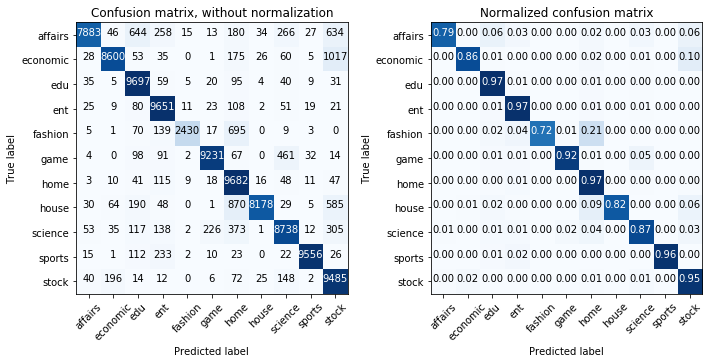

In [53]:
class_names = np.unique(true_labels)
conf_mat = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10,10))
plt.subplot(121)
plot_confusion_matrix(conf_mat, class_names, title='Confusion matrix, without normalization')
plt.subplot(122)
plot_confusion_matrix(conf_mat, class_names, normalize=True, title='Normalized confusion matrix')

Nous pouvons constater que en général ce classifieur a une bonne performance. Mais pour certaines catégories par exemple "fashion", la performance n'est pas très bonne.

----
# 4. Entraîner les modèles de représentation de mots par FastText

- Il existe deux types de modèles:
    1. Skipgram modèle
    2. CBOW modèle

Les librairies [fasttext](https://pypi.org/project/fasttext/) et [gensim](https://radimrehurek.com/gensim/) permet d'entraîner les deux modèles en utilisant [FastText](https://radimrehurek.com/gensim/models/fasttext.html) et [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html). Nous allons commencer par Fasttext

----
Nous avons utilisé les paramètres par défault pour entraîner ces modèles. Quelques paramètres importants:

| Paramètre | Value |
| --------- | ----- |
| epoch | 5 |
| vector_size | 100 |
| min_count | 5 |
| window_size | 5 |


In [6]:
# Modèle Skipgram 
tic = time.time()
model_skipgram = fasttext.skipgram('datasets/news_pure_nolabel.txt', 'model_skipgram')
toc = time.time()
print('Time used to train skipgram word representation model: ' + str(toc - tic) + "s")

print("Vocabulary size: " + str(len(model_skipgram.words))) # list of words in dictionary

Time used to train skipgram word representation model: 487.47211360931396
183312


In [7]:
# Modèle CBOW
tic = time.time()
model_cbow = fasttext.cbow('datasets/news_pure_nolabel.txt', 'model_cbow')
toc = time.time()
print('Time used to train cbow word representation model: ' + str(toc - tic) + "s")

print("Vocabulary size: " + str(len(model_cbow.words))) # list of words in dictionary

Time used to train cbow word representation model: 180.20052647590637
183312


----
# 5. Entraîner le modèle de représentation de mots par Word2Vec

Nous utilisons le module Word2Vec de package [gensim](https://radimrehurek.com/gensim/) pour faire l'apprentissage de modèle. Pareil comme FastText, nous allons entraîner Skipgram et CBOW avec les paramètres principaux comme FastText.

In [31]:
file_path = 'datasets/news_pure_nolabel.txt'

# Modèle Skipgram
tic = time.time()
model_word2vec = Word2Vec(LineSentence(file_path), workers=6, sg=1)
toc = time.time()
print("Time used to train a word2vec_skipgram word representation model: " + str(toc - tic) + "s")

# Sauvegarder le modèle et les vecteurs entraînés
model_word2vec.save('word2vec_skip.model')
model_word2vec.wv.save_word2vec_format('word2vec_skip.txt',binary = False)

Time used to train a word2vec_skipgram word representation model: 520.1113519668579s


In [32]:
# Modèle CBOW
tic = time.time()
model_word2vec = Word2Vec(LineSentence(file_path), workers=6)
toc = time.time()
print("Time used to train a word2vec_cbow word representation model: " + str(toc - tic) + "s")

# Sauvegarder le modèle et les vecteurs entraînés
model_word2vec.save('word2vec_cbow.model')
model_word2vec.wv.save_word2vec_format('word2vec_cbow.txt',binary = False)

Time used to train a word2vec_cbow word representation model: 219.7475070953369s


----
# 6. Entraîner le modèle de représentation de mots par GloVe

L'entraînement de modèle est fait depuis les [code source](https://nlp.stanford.edu/projects/glove/) de Stanford. Il n'existe pas de librairie python, donc nous allons exécuter les lignes de commande pour l'entraînement. Les paramètres principaux sont les même que ceux d'avant.

- D'abord nous comptons le nombre d'occurrence pour chaque mot qui apparaît au minimum 5 fois et stockons les résultat dans le fichier ***news_vocab***

In [33]:
stdout, stderr = subprocess.Popen("GloVe-1.2/build/vocab_count -min-count 5 -verbose 1 < datasets/news_pure_nolabel.txt > news_vocab", 
                                  stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True).communicate()
print(stdout.decode('utf-8'))
print(stderr.decode('utf-8'))


BUILDING VOCABULARY
Truncating vocabulary at min count 5.
Using vocabulary of size 183311.




- Ensuite nous calculons la matrice de co-occurrence des mots avec ***window_size = 5*** et stockons la matrice dans le fichier ***news_cooccur.bin***

In [34]:
stdout, stderr = subprocess.Popen("GloVe-1.2/build/cooccur -memory 4.0 -vocab-file news_vocab -verbose 1 -window-size 5 < datasets/news_pure_nolabel.txt > news_cooccur.bin", 
                                  stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True).communicate()
print(stdout.decode('utf-8'))
print(stderr.decode('utf-8'))


COUNTING COOCCURRENCES
window size: 5
context: symmetric
Merging cooccurrence files: processed 93438016 lines.




- Nous allons mélanger la matrice et le stocker dans le fichier ***news_shuffle.bin***

In [35]:
stdout, stderr = subprocess.Popen("GloVe-1.2/build/shuffle -memory 4.0 -verbose 1 < news_cooccur.bin > news_shuffle.bin", 
                                  stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True).communicate()
print(stdout.decode('utf-8'))
print(stderr.decode('utf-8'))


SHUFFLING COOCCURRENCES
array size: 255013683
Merging temp files: processed 0 lines.93438016 lines.Merging temp files: processed 93438016 lines.




- Maintenant nous allons entraîner le modèle GloVe avec les paramètres principaux comme d'avant

In [36]:
tic = time.time()
stdout, stderr = subprocess.Popen("GloVe-1.2/build/glove -save-file glove -threads 8 -input-file news_shuffle.bin -vocab-file news_vocab -x-max 10 -iter 5 -vector-size 100 -write_header 1 -binary 2 -verbose 1", 
                                  stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True).communicate()
toc = time.time()
print(stdout.decode('utf-8'))
print(stderr.decode('utf-8'))
print("Time used to train a glove word representation model: " + str(toc - tic) + "s")


TRAINING MODEL
Read 93438016 lines.
vector size: 100
vocab size: 183311
x_max: 10.000000
alpha: 0.750000
iter: 001, cost: 0.092556
iter: 002, cost: 0.068930
iter: 003, cost: 0.059226
iter: 004, cost: 0.053823
iter: 005, cost: 0.050688

Time used to train a glove word representation model: 261.8131902217865s


- Pour que le fichier de vecteurs de mots puisse être utilisé pour l'évaluation comme les deux autre méthodes, nous allons ajouter une ligne dans ***glove.txt*** pour indiquer le nombre de mots et la taille de vecteur

In [37]:
lines = 0
glove_file = "glove.txt"
with open(glove_file) as f:
    for line in f:
        lines += 1
print('Total number of word: ' + str(lines))
line = str(lines) + " 100"
subprocess.Popen("sed -i '1 i {}' {}".format(line, glove_file), shell=True).communicate()

Total number of word: 183312


(None, None)

----
# 7. Évaluation des vecteurs de mots

- Après avoir entraîné le modèle, il y a trois applications de modèles usuelles:
    1. Chercher un ensemble de mots qui resemble à un mot donné
    2. Calculer le niveau de similarité de deux mots
    3. Déterminer le mot qui est différent que les autres mots dans un ensemble
    
- Dans cette partie, pour faire l'évaluation, nous utilisons le module de Word2Vec dans le package gensim. Les idées de tests viennent de [documentation de module Word2Vec dans le package gensim](https://radimrehurek.com/gensim/models/word2vec.html).

---
- Cette partie est de chercher 5 mots qui resemblent le plus à un mot donné

In [61]:
req_count = 5
model_word2vec = Word2Vec.load('word2vec_skip.model')
for key in model_word2vec.wv.similar_by_word('老婆', topn =100):
    if len(key[0])==3:
        req_count -= 1
        print(key[0], key[1])
        if req_count == 0:
            break;

儿媳妇 0.8155339956283569
女朋友 0.8100427389144897
男朋友 0.7818666696548462
老伴儿 0.7709515690803528
徐淑敏 0.7657476663589478


Les résultats montre que les quatre mots qui sont plus proche de mot *épouse* sont *belle-fille*, *petite amie*, *petit ami*, et un mot spéciale utilisé entre les personnes agées. Le cinqième mot est le nom d'une femme.

----
- Cette partie est de calculer le niveau de similarité de deux mots

In [68]:
print('le niveau de similarité de deux mots "pierre" et "sable": ' + str(model_word2vec.wv.similarity('石头', '沙子')))
print("le niveau de similarité de deux villes dans la province Guangdong: " + str(model_word2vec.wv.similarity('深圳', '广州')))
print('le niveau de similarité entre "Shenzhen" et "Université de Shenzhen": ' + str(model_word2vec.wv.similarity('深圳', '深圳大学')))

le niveau de similarité de deux mots "pierre" et "sable": 0.6345346
le niveau de similarité de deux villes dans la province Guangdong: 0.88588494
le niveau de similarité entre "Shenzhen" et "Université de Shenzhen": 0.45369726


----
- Cette partie est de déterminer le mot qui est différent que les autres mots dans un ensemble

In [69]:
print(model_word2vec.wv.doesnt_match(u"英国 法国 西班牙 意大利 中国".split()))

中国


Les cinq mots sont : le Royaume-Uni, la France, l'Espagne, l'Italie et la Chine. Le résultat est la Chine.

----
Nous allons aussi utiliser le jeu de données [CA8](https://github.com/Embedding/Chinese-Word-Vectors.git) avec la méthode d'évaluation proposée par les auteurs de CA8 pour évaluer la qualité de vecteurs de mots entraînés. L'explication en détail de jeu de données est sur notre rapport. En donnant une question avec quatre mots : A, B, C et D, l'évaluation ***add*** est basé sur la conception $B - A = D - C$. Il calcule $G = B - A + C$ et trouve le mot qui est plus similaire que G. La précision est définie comme $\frac{nb_{G = D}}{nb_{questions}}$. L'évaluation ***mul*** est construit depuis $\frac{B}{A} = \frac{D}{C}$. L'idée est de calculer $G = \frac{B}{A} * {C}$.

----
Nous allons évaluer les Embedding de GloVe et Word2Vec SkipGram sur les questions sémantiques pour faire un exemple. 
Les résultats d'évaluation complète sont aussi dans notre rapport.

In [1]:
%run Chinese-Word-Vectors/evaluation/ana_eval_dense.py -v glove.txt -a Chinese-Word-Vectors/testsets/CA8/semantic.txt

geography add/mul: 0.091/0.077
nature add/mul: 0.084/0.052
history add/mul: 0.0/0.0
people add/mul: 0.137/0.101
Total accuracy (add): 0.093
Total accuracy (mul): 0.072


In [2]:
%run Chinese-Word-Vectors/evaluation/ana_eval_dense.py -v word2vec_skip.txt -a Chinese-Word-Vectors/testsets/CA8/semantic.txt

geography add/mul: 0.119/0.118
nature add/mul: 0.123/0.1
history add/mul: 0.0/0.0
people add/mul: 0.141/0.138
Total accuracy (add): 0.12
Total accuracy (mul): 0.113


----
Les résultats nous montrent que Word2Vec SkipGram a eu une meilleur précision que GloVe.

Nous utilisons aussi un classifieur de texte pour évaluer les qualités d'Embedding. Voir le notebook *Text Classification Pipeline*